In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Necessary imports and Installations**

In [ ]:
!pip install optuna
!pip install optuna-integration[tfkeras]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Scikit-Learn Imports
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

# TensorFlow / Keras Imports
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, optimizers
import optuna
from optuna.integration import TFKerasPruningCallback

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

**Loading Data and Performing EDA**

In [ ]:
def load_data(csv_path="/content/drive/MyDrive/ML_Project2/covtype.csv"):
    if os.path.exists(csv_path):
        print(f"Loading from local CSV: {csv_path}")
        df = pd.read_csv(csv_path)
        X = df.drop('Cover_Type', axis=1)
        y = df['Cover_Type']
    else:
        print("CSV not found. Fetching from Scikit-Learn (downloading)...")
        data = fetch_covtype()
        X = pd.DataFrame(data.data, columns=data.feature_names)
        y = pd.Series(data.target)
    return X, y

def perform_eda(X, y):
    print("\n" + "="*40)
    print(" EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*40)
    df_temp = X.copy()
    df_temp['Target'] = y

    # Class Distribution
    print("Class Balance:\n", df_temp['Target'].value_counts(normalize=True))

    # Simple Countplot
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Target', data=df_temp, palette='viridis')
    plt.title("Distribution of Forest Cover Types")
    plt.show()

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/ML_Project2/covtype.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [ ]:

pd.set_option('display.max_columns', None)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [ ]:

soil_cols = [f"Soil_Type{i}" for i in range(1, 41)]

df["soil_sum"] = df[soil_cols].sum(axis=1)

df["soil_sum"].unique()


array([1])

In [ ]:


df["soil_type"] = df[soil_cols].idxmax(axis=1)
df["soil_type"] = df["soil_type"].str.extract("(\d+)").astype(int)
df.drop(columns=["soil_sum"], inplace=True)



<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1930904547.py:2: SyntaxWarning: invalid escape sequence '\d'
  df["soil_type"] = df["soil_type"].str.extract("(\d+)").astype(int)


In [ ]:
df.drop(columns=soil_cols, inplace=True)

In [ ]:
w_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]

df["Wilderness_sum"] = df[w_cols].sum(axis=1)

df["Wilderness_sum"].unique()

array([1])

In [ ]:
df["wilderness_area"] = df[w_cols].idxmax(axis=1)
df["wilderness_area"] = df["wilderness_area"].str.extract(r"(\d+)").astype(int)
df.drop(columns=["Wilderness_sum"], inplace=True)

In [ ]:
df.drop(columns=w_cols,inplace=True)

In [ ]:
#Changing soil type and wilderness area and cover type to categorical
df['soil_type']=df['soil_type'].astype('category')
df['wilderness_area']=df['wilderness_area'].astype('category');
df['Cover_Type']=df['Cover_Type'].astype('int64')
df.to_csv("covtype_clean.csv",index=False)

KeyError: 'wilderness_area'

In [ ]:
# Re-create soil_type and wilderness_area columns and drop original ones

# Ensure 'soil_type' is created from original Soil_Type columns
soil_cols = [f"Soil_Type{i}" for i in range(1, 41)]
if any(col in df.columns for col in soil_cols):
    df["soil_type"] = df[soil_cols].idxmax(axis=1)
    df["soil_type"] = df["soil_type"].str.extract(r"(\d+)").astype(int)
    df.drop(columns=soil_cols, inplace=True)
    print("Created 'soil_type' and dropped original Soil_Type columns.")
else:
    print("Soil_Type columns not found. Assuming 'soil_type' already created or not applicable.")

# Ensure 'wilderness_area' is created from original Wilderness_Area columns
w_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
if any(col in df.columns for col in w_cols):
    df["wilderness_area"] = df[w_cols].idxmax(axis=1)
    df["wilderness_area"] = df["wilderness_area"].str.extract(r"(\d+)").astype(int)
    # Check and drop 'Wilderness_sum' if it exists, from a prior step
    if "Wilderness_sum" in df.columns:
        df.drop(columns=["Wilderness_sum"], inplace=True)
    df.drop(columns=w_cols, inplace=True)
    print("Created 'wilderness_area' and dropped original Wilderness_Area columns.")
else:
    print("Wilderness_Area columns not found. Assuming 'wilderness_area' already created or not applicable.")


Soil_Type columns not found. Assuming 'soil_type' already created or not applicable.
Wilderness_Area columns not found. Assuming 'wilderness_area' already created or not applicable.


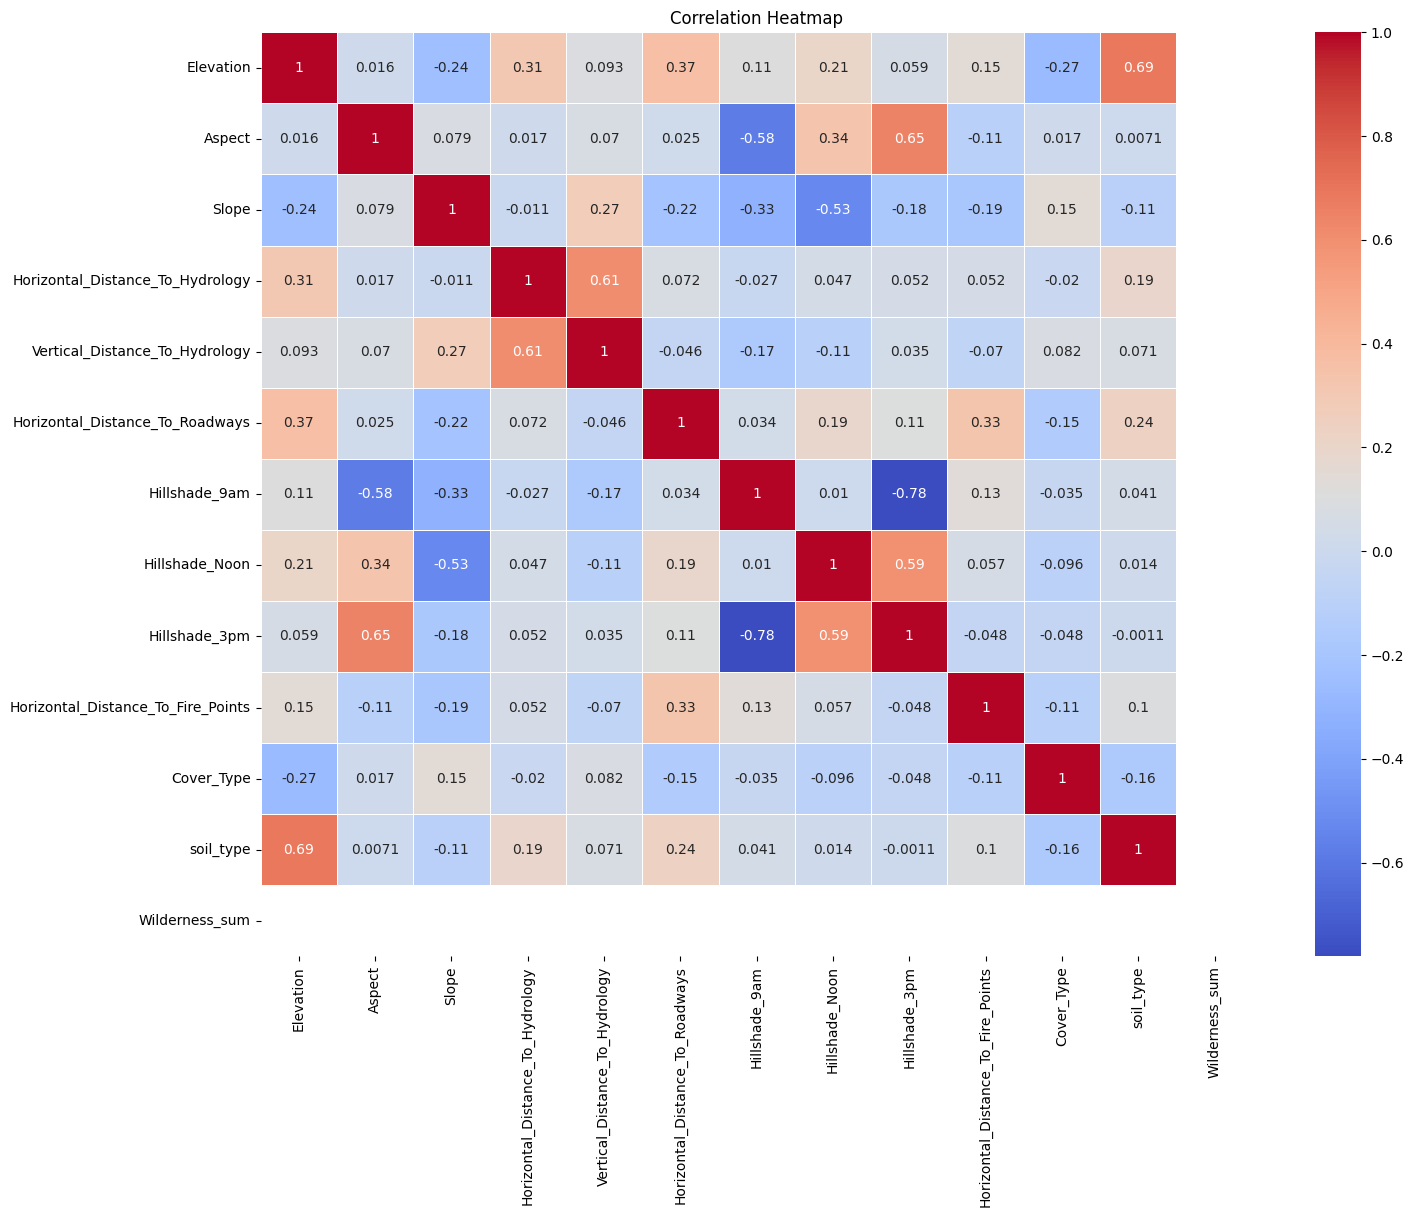

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(16,12));
corr=df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
corr_with_target = df.corr()["Cover_Type"].sort_values(ascending=False)
print(corr_with_target)

Cover_Type                            1.000000
Slope                                 0.148285
Vertical_Distance_To_Hydrology        0.081664
Aspect                                0.017080
Horizontal_Distance_To_Hydrology     -0.020317
Hillshade_9am                        -0.035415
Hillshade_3pm                        -0.048290
Hillshade_Noon                       -0.096426
Horizontal_Distance_To_Fire_Points   -0.108936
Horizontal_Distance_To_Roadways      -0.153450
soil_type                            -0.164337
Elevation                            -0.269554
Wilderness_sum                             NaN
Name: Cover_Type, dtype: float64


In [ ]:
PCA and t-SNE have been used for reducing the dimension to 2 for visualization. It can be seen that the classes in cover_type(target) are not linearly separable. Also many classes overlap and boundary between them are fuzzy. Many forest cover types share similar combination of terrain features .

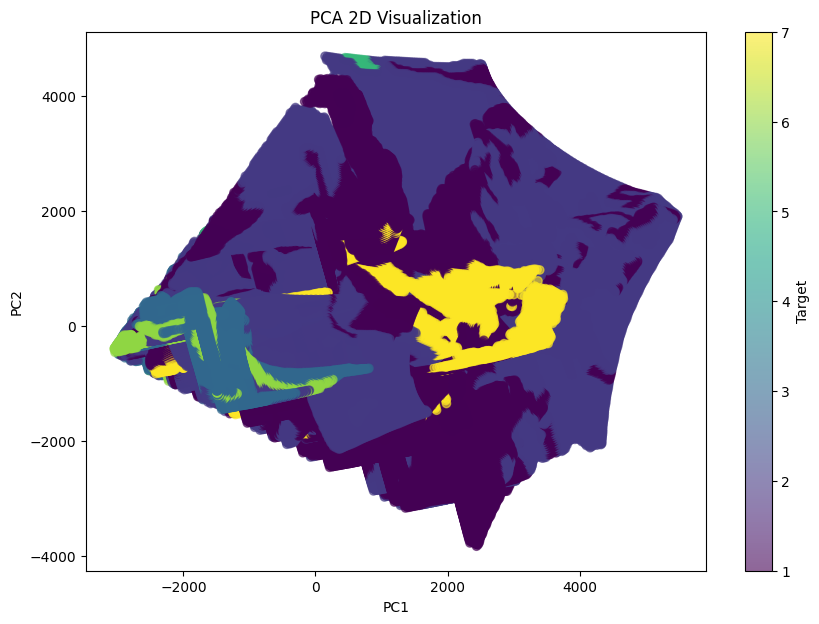

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop("Cover_Type", axis=1))

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["Cover_Type"], cmap='viridis', alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Visualization")
plt.colorbar(label="Target")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


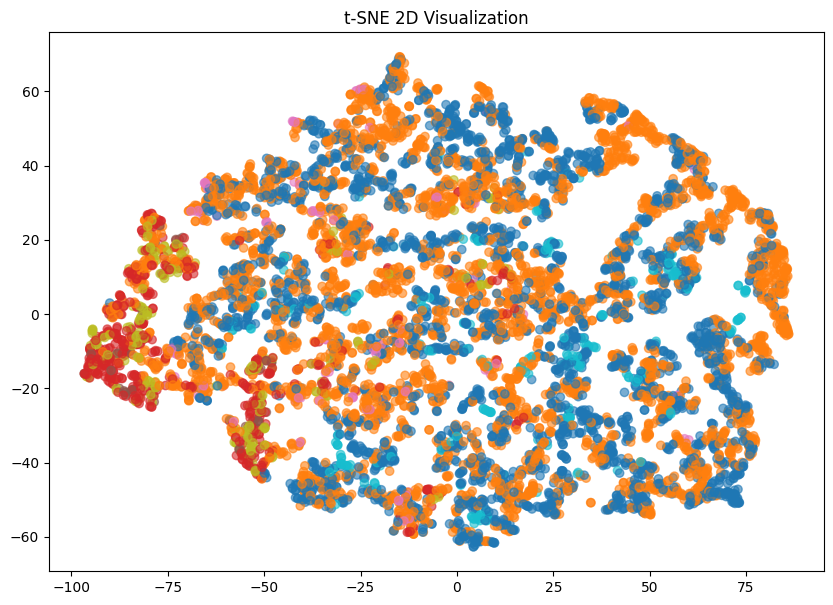

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=1000)

X_sample = df.sample(8000)  # reduce data size
X_tsne = tsne.fit_transform(X_sample.drop("Cover_Type", axis=1))

plt.figure(figsize=(10,7))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=X_sample["Cover_Type"], cmap='tab10', alpha=0.6)
plt.title("t-SNE 2D Visualization")
plt.show()

In [ ]:
df['Cover_Type'].value_counts()

,count
Cover_Type,
2,283301
1,211840
3,35754
7,20510
6,17367
5,9493
4,2747


In [ ]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,soil_type,Wilderness_sum
0,2596,51,3,258,0,510,221,232,148,6279,5,29,1
1,2590,56,2,212,-6,390,220,235,151,6225,5,29,1
2,2804,139,9,268,65,3180,234,238,135,6121,2,12,1
3,2785,155,18,242,118,3090,238,238,122,6211,2,30,1
4,2595,45,2,153,-1,391,220,234,150,6172,5,29,1


TARGET VARIABLE ANALYSIS:The class distribution analysis reveals that the dataset suffers from severe class imbalance. Cover Type 2 (Lodgepole Pine) is the dominant class, accounting for approximately 48.76% of the total samples, followed by Cover Type 1 (Spruce/Fir) at 36.46%. In contrast, Cover Type 4 (Cottonwood/Willow) represents only 0.47% of the data, making it the most underrepresented class. Other minority classes include Aspen (1.63%), Douglas-fir (2.99%), and Krummholz (3.53%).

In [ ]:
class_counts = df['Cover_Type'].value_counts().sort_index()
print(class_counts)

Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


In [ ]:
class_percent = df['Cover_Type'].value_counts(normalize=True).sort_index() * 100
print(class_percent)

Cover_Type
1    36.460521
2    48.759922
3     6.153746
4     0.472796
5     1.633873
6     2.989095
7     3.530048
Name: proportion, dtype: float64


In [ ]:
# Identify variable groups
num_cols = ['Elevation', 'Aspect', 'Slope',
            'Horizontal_Distance_To_Hydrology',
            'Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways',
            'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
            'Horizontal_Distance_To_Fire_Points']

wilderness_cols = [col for col in df.columns if "Wilderness_Area" in col]
soil_cols       = [col for col in df.columns if "Soil_Type" in col]

print("Numeric Columns:", num_cols)
print("\nWilderness Columns:", wilderness_cols)
print("\nSoil Type Columns:", soil_cols)
df.groupby("Cover_Type")[num_cols].mean().T


Numeric Columns: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

Wilderness Columns: ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']

Soil Type Columns: ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


Cover_Type,1,2,3,4,5,6,7
Elevation,3128.644888,2920.936061,2394.509845,2223.939934,2787.417571,2419.181897,3361.928669
Aspect,156.138227,152.060515,176.372490,137.139425,139.283051,180.539068,153.236226
Slope,13.127110,13.550499,20.770208,18.528941,16.641315,19.048886,14.255924
Horizontal_Distance_To_Hydrology,270.555245,279.916442,210.276473,106.934838,212.354893,159.853458,356.994686
Vertical_Distance_To_Hydrology,42.156939,45.884219,62.446915,41.186749,50.610344,45.437439,69.474305
Horizontal_Distance_To_Roadways,2614.834517,2429.530799,943.940734,914.199490,1349.765722,1037.169805,2738.250463
Hillshade_9am,211.998782,213.844423,201.918415,228.345832,223.474876,192.844302,216.967723
Hillshade_Noon,223.430211,225.326596,215.826537,216.997088,219.035816,209.827662,221.746026
Hillshade_3pm,143.875038,142.983466,140.367176,111.392792,121.920889,148.284044,134.932033
Horizontal_Distance_To_Fire_Points,2009.253517,2168.154849,910.955949,859.124135,1577.719794,1055.351471,2070.031594


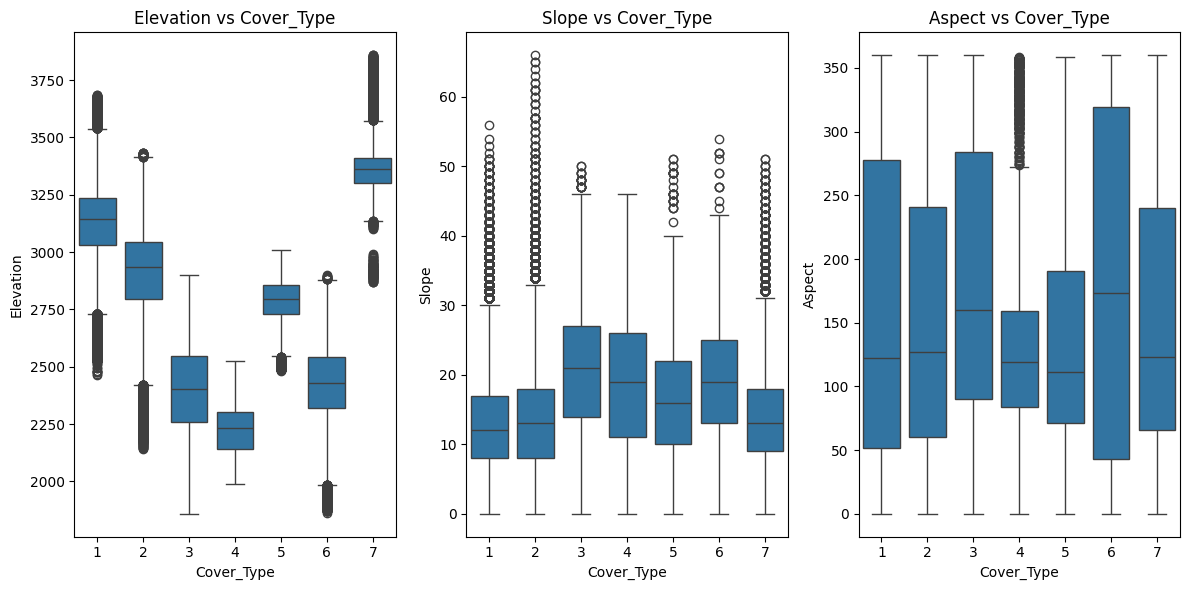

In [ ]:
plt.figure(figsize=(12,6))
for i, col in enumerate(['Elevation','Slope','Aspect']):
    plt.subplot(1,3,i+1)
    sns.boxplot(data=df, x="Cover_Type", y=col)
    plt.title(f"{col} vs Cover_Type")

plt.tight_layout()
plt.show()

In [ ]:
#Outlier detection :
from scipy.stats import zscore

z_df = df[num_cols].apply(zscore)
outliers = (abs(z_df) > 3).sum().sort_values(ascending=False)
outliers

,0
Horizontal_Distance_To_Fire_Points,10853
Vertical_Distance_To_Hydrology,10059
Hillshade_9am,7516
Hillshade_Noon,7082
Horizontal_Distance_To_Hydrology,7073
Elevation,5832
Slope,4074
Hillshade_3pm,3042
Horizontal_Distance_To_Roadways,33
Aspect,0


Univariate Analysis

In [ ]:
features = [
    "Elevation",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm"
]

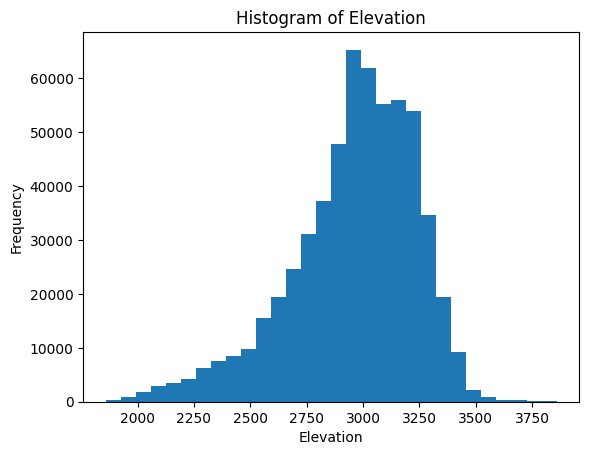

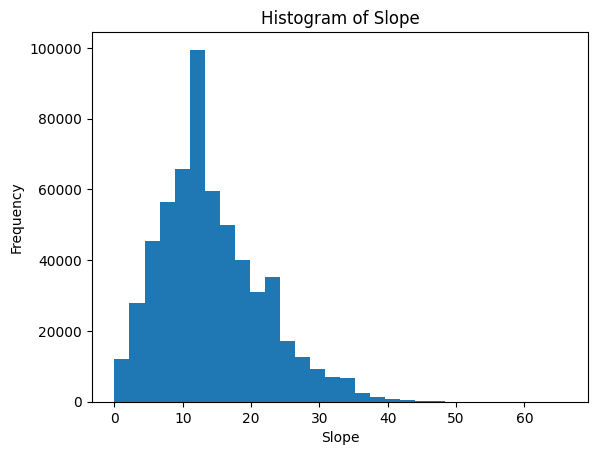

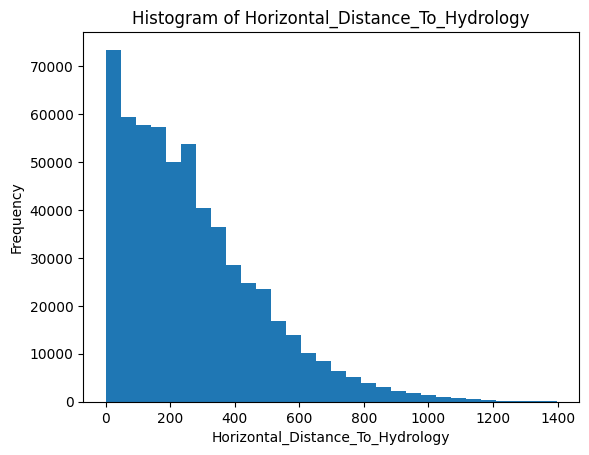

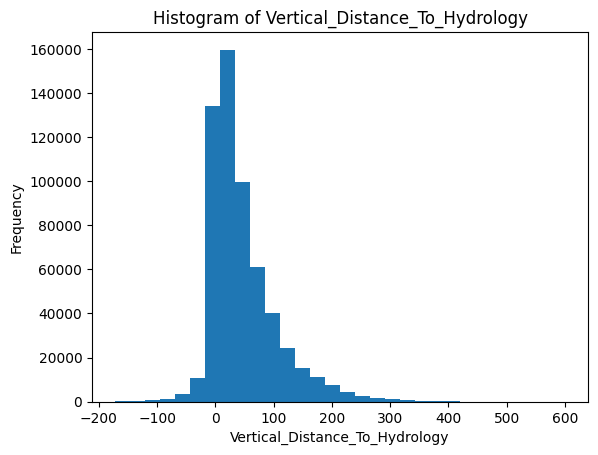

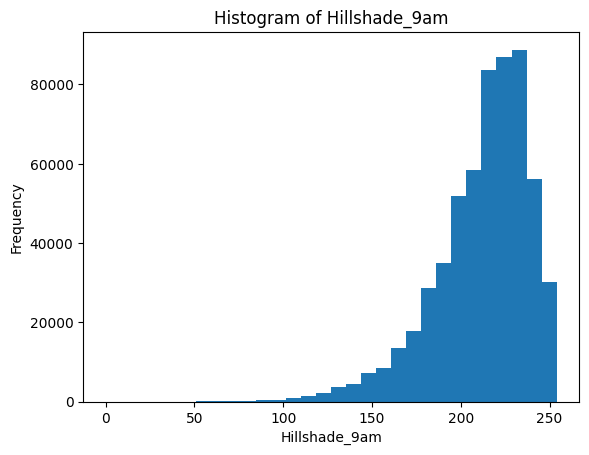

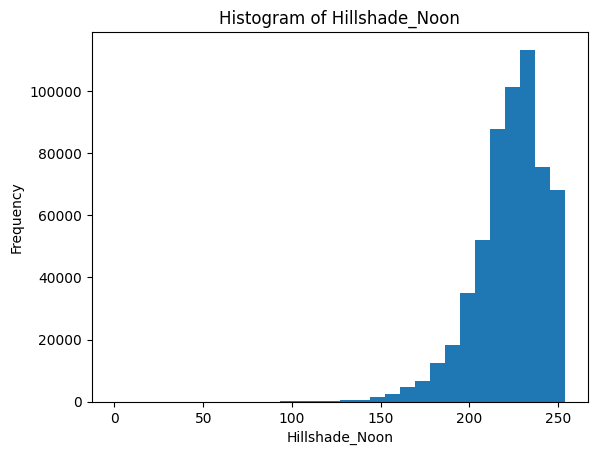

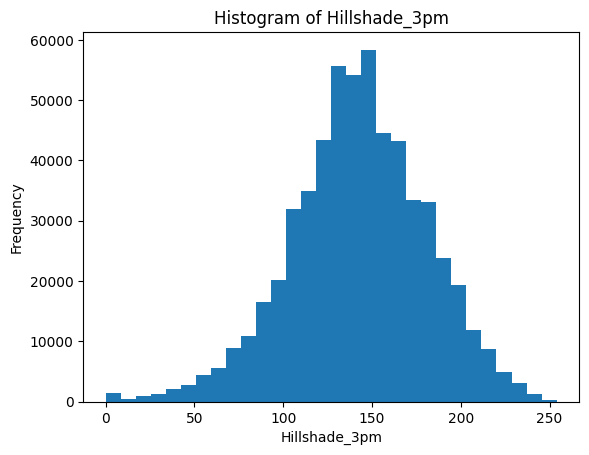

In [ ]:
import matplotlib.pyplot as plt
for feature in features:
    plt.figure()
    plt.hist(df[feature], bins=30)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {feature}")
    plt.show()

Bivariate Analysis:Elevation vs Cover Type

A clear stratification of forest types along the elevation gradient is observed. Krummholz (Class 7) and Spruce/Fir (Class 1) occur predominantly at higher elevations, indicating their strong association with cold, high-altitude environments. Lodgepole Pine (Class 2) is distributed across moderately high elevations, whereas Ponderosa Pine (Class 3) and Douglas-fir (Class 6) are mainly concentrated at lower to mid-elevation ranges.

Cottonwood/Willow (Class 4) exhibits the lowest elevation range among all classes, reflecting its preference for low-lying riparian zones. Aspen (Class 5) is observed at intermediate elevations with comparatively lower variability. The presence of several outliers across classes highlights localized terrain variations.

These results confirm that elevation is a highly discriminatory cartographic feature and serves as a major ecological driver governing forest cover distribution in the study area.

<Figure size 640x480 with 0 Axes>

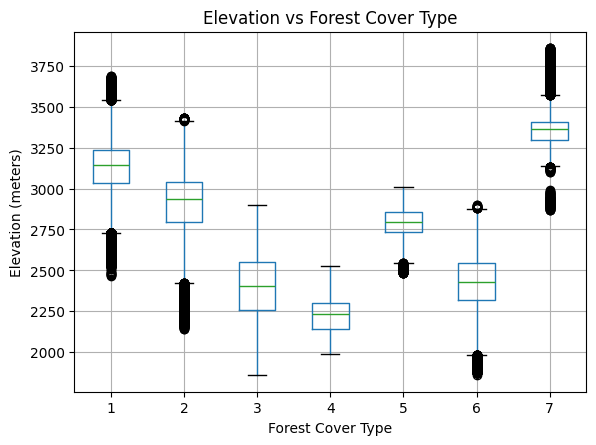

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column="Elevation", by="Cover_Type")
plt.xlabel("Forest Cover Type")
plt.ylabel("Elevation (meters)")
plt.title("Elevation vs Forest Cover Type")
plt.suptitle("")
plt.show()



Horizontal distance to hydrology vs cover type

A strong relationship between proximity to water and forest type is clearly observed. Cottonwood/Willow (Class 4) exhibits the smallest me- dian distance to hydrological features, with most samples occurring very close to water sources. This confirms its strong association with riparian environments. In contrast, forest types such as Lodgepole Pine (Class 2), Krummholz (Class 7), and Spruce/Fir (Class 1) display significantly larger median distances and wider spreads, indicating weaker dependence on immediate water proximity. Aspen (Class 5) and Douglas-fir (Class 6) occur at intermediate hydrological distances. The presence of several high-distance outliers across multiple classes reflects natural terrain variability and heterogeneous drainage patterns within the study region. Overall, these results validate horizontal distance to hydrology as a highly discriminative feature for forest cover classification

<Figure size 640x480 with 0 Axes>

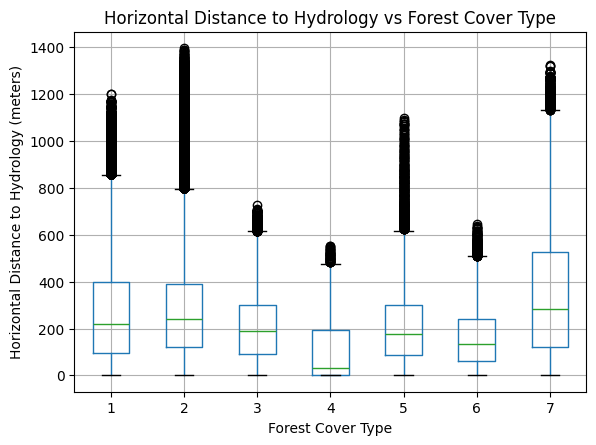

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column="Horizontal_Distance_To_Hydrology", by="Cover_Type")
plt.xlabel("Forest Cover Type")
plt.ylabel("Horizontal Distance to Hydrology (meters)")
plt.title("Horizontal Distance to Hydrology vs Forest Cover Type")
plt.suptitle("")
plt.show()

Slope vs Cover Type

Distinct slope preferences are observed among the classes. Ponderosa Pine (Class 3), Cottonwood/Willow (Class 4), and Douglas-fir (Class 6) exhibit higher median slope values, indicating a tendency to grow on moderately to steeply sloped terrains.

Spruce/Fir (Class 1), Lodgepole Pine (Class 2), and Krummholz (Class 7) are predominantly concentrated at lower slope ranges, suggesting their preference for relatively gentle terrains. Aspen (Class 5) occupies an intermediate slope range with moderate variability.

Several high-slope outliers are present across nearly all forest types, reflecting natural terrain irregularities such as ridges and steep inclines. Overall, slope demonstrates moderate discriminative power in distinguishing forest cover types based on terrain steepness.

<Figure size 640x480 with 0 Axes>

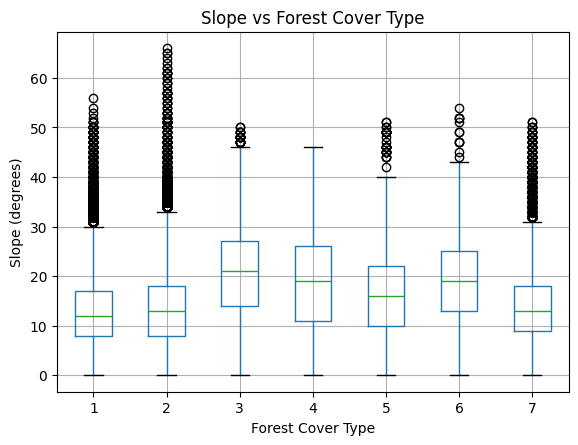

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column="Slope", by="Cover_Type")
plt.xlabel("Forest Cover Type")
plt.ylabel("Slope (degrees)")
plt.title("Slope vs Forest Cover Type")
plt.suptitle("")
plt.show()

Horizontal Distance to Roadways vs Forest Cover Type

Clear differences in accessibility patterns are observed among the classes. Cottonwood/Willow (Class 4), Ponderosa Pine (Class 3), and Douglas- fir (Class 6) exhibit smaller median distances to roadways, indicating that these forest types are more frequently located in relatively accessible regions. In contrast, Spruce/Fir (Class 1), Lodgepole Pine (Class 2), and Krummholz (Class 7) show substantially larger median distances and wider spreads, suggest- ing that these forest types are predominantly found in remote and less accessible areas. Aspen (Class 5) occupies a moderate range with substantial variability. The presence of several extreme outliers at high distances reflects naturally inaccessible mountainous and interior forest regions.

<Figure size 640x480 with 0 Axes>

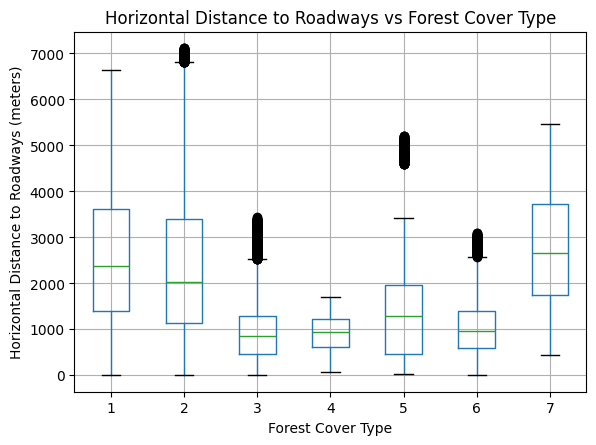

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column="Horizontal_Distance_To_Roadways", by="Cover_Type")
plt.xlabel("Forest Cover Type")
plt.ylabel("Horizontal Distance to Roadways (meters)")
plt.title("Horizontal Distance to Roadways vs Forest Cover Type")
plt.suptitle("")
plt.show()

Wilderness Area vs Forest Cover Type

A strong geographical specialization of forest types is clearly evident. Lodgepole Pine (Class 2) and Spruce/Fir (Class 1) dominate Wilderness Areas 1 and 3, indicating that these regions primarily consist of high-altitude coniferous forests. Wilderness Area 3 exhibits the highest diversity of forest types, containing substantial representations of Aspen (Class 5), Douglas-fir (Class 6), Ponderosa Pine (Class 3), and Krummholz (Class 7). In contrast, Wilderness Area 2 shows a comparatively lower number of samples and is primarily dominated by Spruce/Fir and Lodgepole Pine. Wilderness Area 4 displays a distinct vegetation profile characterized by a strong dominance of Ponderosa Pine (Class 3) and Douglas-fir (Class 6), with minimal presence of high-altitude forest types. These observations confirm that wilderness area is a highly influential geographical feature governing forest cover distribution

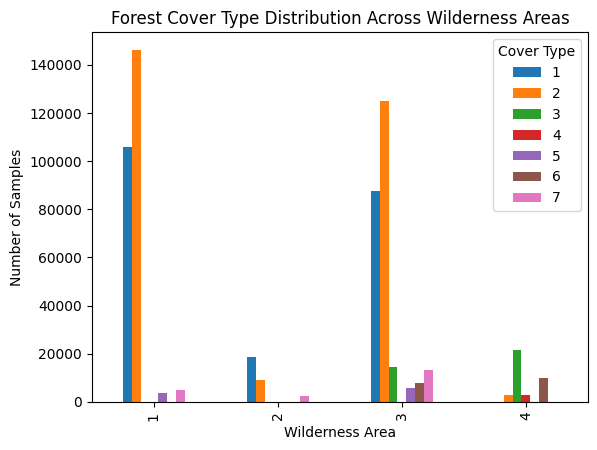

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create frequency table
wilderness_cover_counts = pd.crosstab(
    df["wilderness_area"],
    df["Cover_Type"]
)

# Plot grouped bar chart
wilderness_cover_counts.plot(kind="bar")
plt.xlabel("Wilderness Area")
plt.ylabel("Number of Samples")
plt.title("Forest Cover Type Distribution Across Wilderness Areas")
plt.legend(title="Cover Type")
plt.show()

<Figure size 1800x800 with 0 Axes>

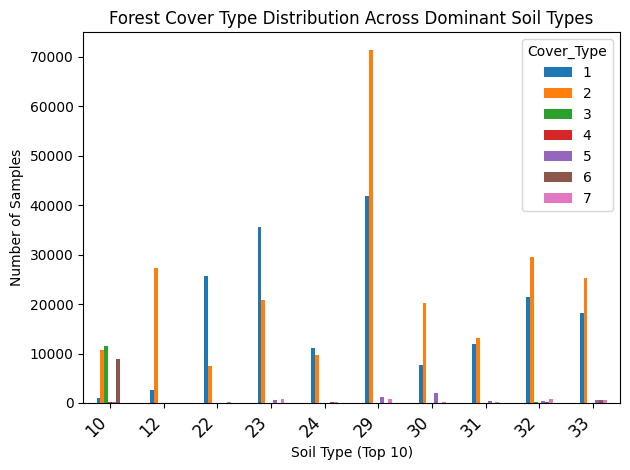

In [ ]:
top_soils = df["soil_type"].value_counts().head(10).index
filtered_df = df[df["soil_type"].isin(top_soils)]

soil_cover_counts = pd.crosstab(
    filtered_df["soil_type"],
    filtered_df["Cover_Type"]
)

plt.figure(figsize=(18, 8))
soil_cover_counts.plot(kind="bar")

plt.xlabel("Soil Type (Top 10)", fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)
plt.title("Forest Cover Type Distribution Across Dominant Soil Types", fontsize=12)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.tight_layout()
plt.show()

**Preprocessing Data**


In [ ]:
def preprocess_data(X, y):
    print("\nSplitting Data: 80% Train, 10% Val, 10% Test...")

    # 1. First Split: Separate Train (80%) from the rest (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 2. Second Split: Split the remaining 20% equally into Val (10%) and Test (10%)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    continuous_cols = [
        'Elevation', 'Aspect', 'Slope',
        'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
        'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
    ]
    binary_cols = [c for c in X.columns if c not in continuous_cols]

    print("Scaling continuous features...")
    scaler = StandardScaler()
    X_train_cont = scaler.fit_transform(X_train[continuous_cols])
    X_val_cont = scaler.transform(X_val[continuous_cols])
    X_test_cont = scaler.transform(X_test[continuous_cols])

    X_train_proc = np.hstack([X_train_cont, X_train[binary_cols].values])
    X_val_proc   = np.hstack([X_val_cont, X_val[binary_cols].values])
    X_test_proc  = np.hstack([X_test_cont, X_test[binary_cols].values])

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc   = le.transform(y_val)
    y_test_enc  = le.transform(y_test)

    return X_train_proc, X_val_proc, X_test_proc, y_train_enc, y_val_enc, y_test_enc, le

def select_features(X_train, y_train, X_val, X_test):
    print("\nPerforming feature selection...")
    if X_train.shape[0] > 50000:
        X_sub, y_sub = resample(X_train, y_train, n_samples=50000, random_state=42, stratify=y_train)
    else:
        X_sub, y_sub = X_train, y_train

    rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    rf.fit(X_sub, y_sub)

    selector = SelectFromModel(rf, prefit=True)
    X_train_sel = selector.transform(X_train)
    X_val_sel   = selector.transform(X_val)
    X_test_sel  = selector.transform(X_test)

    print(f"Features reduced from {X_train.shape[1]} to {X_train_sel.shape[1]}")
    return X_train_sel, X_val_sel, X_test_sel, selector

Loading from local CSV: /content/drive/MyDrive/ML_Project2/covtype.csv

 EXPLORATORY DATA ANALYSIS (EDA)
Class Balance:
 Target
2    0.487599
1    0.364605
3    0.061537
7    0.035300
6    0.029891
5    0.016339
4    0.004728
Name: proportion, dtype: float64


/tmp/ipython-input-78031629.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=df_temp, palette='viridis')


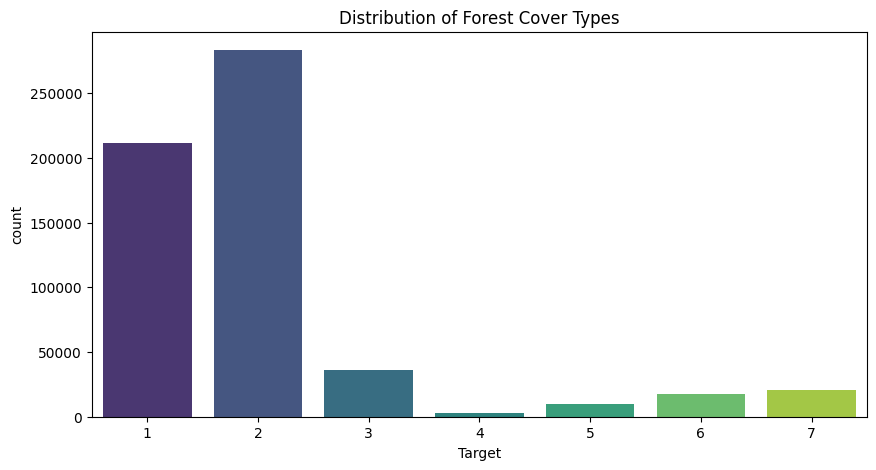


Splitting Data: 80% Train, 10% Val, 10% Test...
Train: (464809, 54), Val: (58101, 54), Test: (58102, 54)
Scaling continuous features...

Performing feature selection...
Features reduced from 54 to 11


In [ ]:
# Load
X_raw, y_raw = load_data("/content/drive/MyDrive/ML_Project2/covtype.csv")
perform_eda(X_raw, y_raw)

# Preprocess
X_train, X_val, X_test, y_train, y_val, y_test, le = preprocess_data(X_raw, y_raw)

# Feature Selection
X_train_sel, X_val_sel, X_test_sel, selector = select_features(X_train, y_train, X_val, X_test)

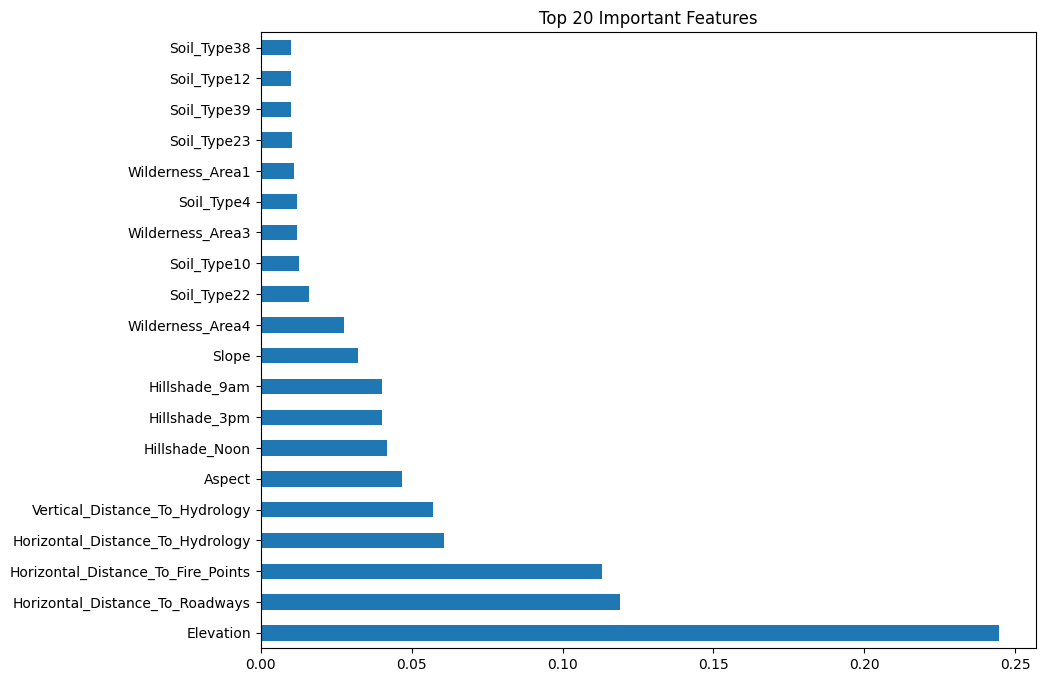

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(df.drop("Cover_Type", axis=1), df["Cover_Type"])

importances = pd.Series(rf.feature_importances_,
                        index=df.drop("Cover_Type", axis=1).columns
                       ).sort_values(ascending=False)

importances.head(20).plot(kind='barh', figsize=(10,8))
plt.title("Top 20 Important Features")
plt.show()

**Model Training and Evaluation**

--- Loading Data from: /content/drive/MyDrive/ML_Project2/covtype.csv ---
Data Loaded Successfully. Shape: (581012, 55)
Target classes encoded: [1 2 3 4 5 6 7] -> [0 1 2 3 4 5 6]

--- Splitting Data (80/10/10) ---
Training Set:   464809 samples (80%)
Validation Set: 58101 samples (10%)
Test Set:       58102 samples (10%)

--- Scaling Features ---

--- Training Logistic Regression ---
  Logistic Regression Test Accuracy: 0.7207
  Training Time: 375.53 seconds

--- Training Linear SVM ---
  Linear SVM Test Accuracy: 0.7112
  Training Time: 221.54 seconds

--- Tuning Neural Network with Optuna ---
  (Tuning on 20k subset to speed up search...)
  Best NN Params: {'n_layers': 3, 'lr': 0.007787931790988289, 'batch_size': 128, 'units_l0': 96, 'dropout_l0': 0.11879950036682313, 'units_l1': 192, 'dropout_l1': 0.14825443551424658, 'units_l2': 256, 'dropout_l2': 0.3581811960722282}
  Training final NN with best params on FULL data...
Epoch 1/50
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - accur

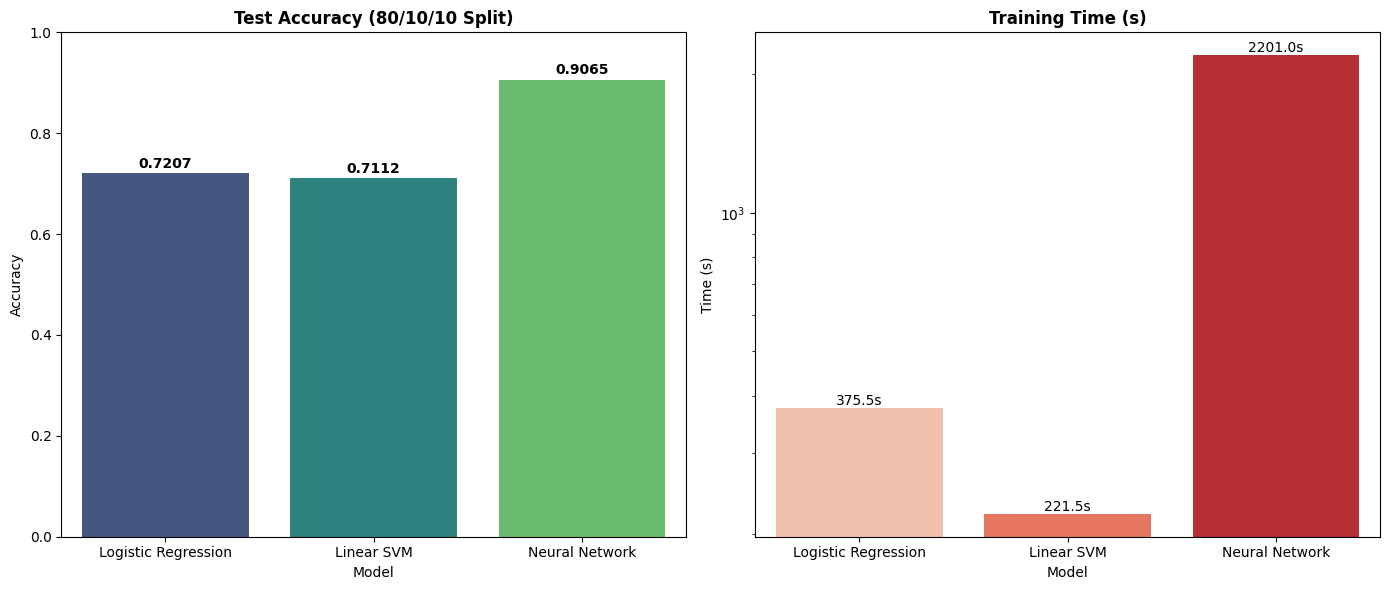

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import resample

# TensorFlow / Keras Imports
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# ==========================================
#  Load Data from Drive
# ==========================================
csv_path = "/content/drive/MyDrive/ML_Project2/covtype.csv"
print(f"--- Loading Data from: {csv_path} ---")

try:
    df = pd.read_csv(csv_path)
    print(f"Data Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("ERROR: File not found at the specified path. Please check the path and try again.")
    # Stop execution if file not found (simulated by raising error)
    raise

# Define X (Features) and y (Target)
# Assumes 'Cover_Type' is the last column, which is standard for this dataset.
# If your target column has a different name, change 'iloc[:, -1]' below.
X = df.iloc[:, :-1].values
y_raw = df.iloc[:, -1].values

# IMPORTANT: Fix Labels for Neural Network
# CovType classes are usually 1-7. Keras needs 0-6.
le = LabelEncoder()
y = le.fit_transform(y_raw)
print(f"Target classes encoded: {le.classes_} -> {np.unique(y)}")

# ==========================================
# 1. Data Splitting (80% Train / 10% Val / 10% Test)
# ==========================================
print("\n--- Splitting Data (80/10/10) ---")

# Step A: Split 80% Train and 20% Temporary (Temp will hold Val + Test)

X_train_raw, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step B: Split the 20% Temporary data equally (50/50) into Validation and Test
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training Set:   {X_train_raw.shape[0]} samples (80%)")
print(f"Validation Set: {X_val_raw.shape[0]} samples (10%)")
print(f"Test Set:       {X_test_raw.shape[0]} samples (10%)")

# ==========================================
# 2. Preprocessing (Scaling)
# ==========================================
print("\n--- Scaling Features ---")
scaler = StandardScaler()

# Fit on Training data only to prevent data leakage
X_train_sel = scaler.fit_transform(X_train_raw)
X_val_sel = scaler.transform(X_val_raw)
X_test_sel = scaler.transform(X_test_raw)

results = {}

# ==========================================
# 3. Traditional Models Helper Function
# ==========================================
def train_sklearn_model(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n--- Training {model_name} ---")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"  {model_name} Test Accuracy: {acc:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

    return acc, train_time

# ==========================================
# 4. Train Logistic Regression
# ==========================================
# Using 'saga' solver which is faster for large datasets like CovType
lr_model = LogisticRegression(
    C=1.0, solver='saga', max_iter=200,
    multi_class='multinomial', n_jobs=-1, random_state=42
)
acc_lr, time_lr = train_sklearn_model("Logistic Regression", lr_model, X_train_sel, y_train, X_test_sel, y_test)
results['Logistic Regression'] = {'Accuracy': acc_lr, 'Time': time_lr}

# ==========================================
# 5. Train Linear SVM
# ==========================================
# dual=False is preferred when n_samples > n_features
svm_model = LinearSVC(
    C=1.0, dual=False, max_iter=1000, random_state=42
)
acc_svm, time_svm = train_sklearn_model("Linear SVM", svm_model, X_train_sel, y_train, X_test_sel, y_test)
results['Linear SVM'] = {'Accuracy': acc_svm, 'Time': time_svm}

# ==========================================
# 6. Neural Network (Optuna Tuning)
# ==========================================
def objective_nn(trial, X_tr, y_tr, X_v, y_v, input_dim, num_classes):
    # Hyperparameter Search Space
    n_layers = trial.suggest_int('n_layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256]) # Larger batches for big data

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    for i in range(n_layers):
        units = trial.suggest_int(f'units_l{i}', 64, 256, step=32)
        dropout = trial.suggest_float(f'dropout_l{i}', 0.1, 0.4)
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Fast tuning (fewer epochs)
    history = model.fit(
        X_tr, y_tr, validation_data=(X_v, y_v),
        epochs=10, batch_size=batch_size,
        callbacks=[TFKerasPruningCallback(trial, 'val_accuracy')], verbose=0
    )
    return history.history['val_accuracy'][-1]

def run_optuna_nn(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n--- Tuning Neural Network with Optuna ---")
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))

    # Subset for faster tuning (CovType is huge, ~500k rows)
    # Tuning on 20k rows is usually sufficient to find good params
    if X_train.shape[0] > 20000:
        print("  (Tuning on 20k subset to speed up search...)")
        X_tune, y_tune = resample(X_train, y_train, n_samples=20000, random_state=42, stratify=y_train)
    else:
        X_tune, y_tune = X_train, y_train

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial: objective_nn(trial, X_tune, y_tune, X_val, y_val, input_dim, num_classes), n_trials=5)

    print("  Best NN Params:", study.best_params)
    bp = study.best_params

    # Final Model Training
    print("  Training final NN with best params on FULL data...")
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    for i in range(bp['n_layers']):
        model.add(layers.Dense(bp[f'units_l{i}'], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(bp[f'dropout_l{i}']))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=bp['lr']),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    t0 = time.time()
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=50, batch_size=bp['batch_size'], callbacks=[es], verbose=1
    )
    train_time = time.time() - t0

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"  Neural Network Test Accuracy: {acc:.4f}")

    return acc, train_time, model

# Run NN
acc_nn, time_nn, nn_model = run_optuna_nn(
    X_train_sel, y_train, X_val_sel, y_val, X_test_sel, y_test
)
results['Neural Network'] = {'Accuracy': acc_nn, 'Time': time_nn}

# ==========================================
# 7. Final Comparison & Plots
# ==========================================
print("\n" + "="*40)
print(" FINAL COMPARISON")
print("="*40)

# Generate Predictions for NN
y_pred_prob_nn = nn_model.predict(X_test_sel)
y_pred_nn = np.argmax(y_pred_prob_nn, axis=1)

# Convert mapped labels back to original (1-7) for readability if needed,
# but for metric calculation we use the encoded versions.
print("\n--- Detailed Classification Report (Neural Net) ---")
print(classification_report(y_test, y_pred_nn, target_names=[str(c) for c in le.classes_]))

# Plotting
df_results = pd.DataFrame(results).T.reset_index()
df_results.columns = ['Model', 'Accuracy', 'Time (s)']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy Plot
sns.barplot(x='Model', y='Accuracy', data=df_results, ax=axes[0], palette='viridis')
axes[0].set_ylim(0, 1.0)
axes[0].set_title('Test Accuracy (80/10/10 Split)', fontweight='bold')
for i, row in df_results.iterrows():
    axes[0].text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.4f}", ha='center', fontweight='bold')

# Time Plot
sns.barplot(x='Model', y='Time (s)', data=df_results, ax=axes[1], palette='Reds')
axes[1].set_title('Training Time (s)', fontweight='bold')
axes[1].set_yscale('log')
for i, row in df_results.iterrows():
    axes[1].text(i, row['Time (s)'], f"{row['Time (s)']:.1f}s", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*40)
print(" NEURAL NETWORK ARCHITECTURE")
print("="*40)
nn_model.summary()


 NEURAL NETWORK ARCHITECTURE


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 96)             │         5,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 192)            │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,687 (897.22 KB)

 Trainable params: 76,199 (297.65 KB)

 Non-trainable params: 1,088 (4.25 KB)

 Optimizer params: 152,400 (595.32 KB)